In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Exercise 3.1

In [ ]:
x = np.linspace(0,1,100)
x1 = np.linspace(0,0.5,50)
x2 = np.linspace(0.5,1,50)
z = np.zeros(50)
y = x*(x**2-3*x+3)/6


#N = [[1-x1,z],[2*x1,(2-2*x2)],[z,2*x2-1]]
Ns = [np.concatenate((1-x1,z), axis=0),np.concatenate((2*x1,(2-2*x2)), axis=0),np.concatenate((z,2*x2-1), axis=0)]
k = np.matrix([[-2,2,0],[2,0,2],[0,-2,2]])
f = np.array([5/24,1/4,1/24])
phi = np.linalg.solve(k,f)

phiT = np.zeros(100)

for i,v in enumerate(Ns):
    phiT += phi[i]*v


plt.plot(x,y)
plt.plot(x,phiT)
plt.show()


# Exercise 3.2

In [ ]:
def S(x):
    return 1-x

def stiffness(nodes):
    return 1/(nodes[-1]-nodes[0])*np.array([[1,-1],[-1,1]])

def force(nodes,S):
    return ((nodes[-1]-nodes[0])/6)*np.array([2*S(nodes[0])+S(nodes[-1]),S(nodes[0])+2*S(nodes[-1])])

def solver(S,Ne,alpha,beta,even_grid=True):
    if even_grid:
        nodes=np.linspace(0,1,Ne+1)
    else:
        nodes = np.array([0, *sorted(np.random.rand(Ne-1)), 1])

    LM = np.zeros((2, Ne), dtype=np.int64)
    for e in range(Ne):
        if e==0:
            LM[0, e] = -1
            LM[1, e] = 0
        else:
            LM[0, e] = LM[1, e-1]
            LM[1, e] = LM[0, e] + 1

    K = np.zeros((Ne, Ne))
    F = np.zeros((Ne,))

    for e in range(Ne):
        k_e = stiffness(nodes[e:e+2])
        f_e = force(nodes[e:e+2],S)
        
        for a in range(2):
            A = LM[a, e]
            
            for b in range(2):
                B = LM[b, e]
                if (A >= 0) and (B >= 0):
                    K[A, B] += k_e[a, b]
            if (A >= 0):
                F[A] += f_e[a]
        # Modify force vector for Dirichlet BC
        if e == 0:
            F[0] -= alpha * k_e[1, 0]
    # Modify force vector for Neumann BC
    F[-1] += beta
    # Solve
    Psi_A = np.zeros_like(nodes)
    Psi_A[0] = alpha
    Psi_A[1:] = np.linalg.solve(K, F)

    # print(F)
    # print(K)

    return nodes, Psi_A

def linear(x,m,c):
    return m*x+c

def L2_norm_error(pred,aim,x):
    return np.sqrt(((pred[-1]-aim(x))**2))/np.sqrt((aim(x)**2))

def order_of_convergence(analytical,S,alpha,beta,Ns=[10,40,80,160]):
    Psis=[]
    L2_norms=[]
    Ns=np.array(Ns)
    for N in Ns:
        nodes,Psi_N=solver(S,N,alpha,beta)
        Psis.append(Psi_N)
        L2_norms.append(L2_norm_error(Psi_N,analytical,nodes[-1]))
    
    m,c=np.polyfit(np.log(Ns),np.log(L2_norms),1)

    plt.loglog(Ns,(m*Ns)/5E15,'o-',label='m='+str(round(m,3)))
    plt.loglog(Ns,L2_norms,'o-',label='L2 error')
    plt.legend()
    plt.grid(which='both',alpha=.6)
    plt.show()


In [ ]:
def ana(x):
    return x*(x**2-3*x+3)/6

alpha=0
beta=0
Ne = 10
x,y=solver(S,Ne,alpha,beta)

x_ana=np.linspace(0,1,100)
y_ana=ana(x_ana)
plt.plot(x_ana,y_ana,label='analytical')
plt.plot(x,y,'o-',label='even grid')

x,y=solver(S,Ne,alpha,beta,False)
plt.plot(x,y,'o-',label='uneven grid')

plt.legend()
plt.show()

order_of_convergence(ana,S,alpha,beta)

In [ ]:
def ana1(x):
    return x*(4-6*x+4*x**2-x**3)/12

x_ana=np.linspace(0,1,100)
y_ana=x_ana*(4-6*x_ana+4*x_ana**2-x_ana**3)/12

def S1(x):
    return (1-x)**2

alpha=0
beta=0
Ne = 10
x,y=solver(S1,Ne,alpha,beta)

plt.plot(x_ana,y_ana,label='analytical')
plt.plot(x,y,'o-',label='even grid')

x,y=solver(S1,Ne,alpha,beta,False)
plt.plot(x,y,'o-',label='uneven grid')

plt.legend()
plt.show()

order_of_convergence(ana1,S1,alpha,beta)

In [ ]:
x_ana=np.linspace(0,1,100)
y_ana=np.zeros(len(x_ana))

def psi_ana(x):
    if x<.25:
        return .3*x+.1
    elif .25<x<.75:
        return -.5*x**2+.55*x+11/160
    elif x>.75:
        return -.2*x+.35
    
for i,v in enumerate(x_ana):
    y_ana[i]=psi_ana(v)

def S2(x):
    if abs(x-.5)<.25:
        return 1
    else:
        return 0

alpha=.1
beta=-.2
Ne = 30
x,y=solver(S2,Ne,alpha,beta)

plt.plot(x_ana,y_ana,label='analytical')
plt.plot(x,y,'o-',label='even grid')

x,y=solver(S2,Ne,alpha,beta,False)
plt.plot(x,y,'o-',label='uneven grid')

plt.legend()
plt.show()

order_of_convergence(psi_ana,S2,alpha,beta)

# 4.3 Algorithm

In [2]:
def shape_functions(xi):
    return np.array([1-xi[0]-xi[1], xi[0], xi[1]])

In [3]:
def div_xi_shape_functions():
    return np.array([[-1,1,0],[-1,0,1]])

In [4]:
def global_x(xi,nodal_x):
    x=np.zeros(2)
    N=shape_functions(xi)
    for i in range(2):
        for j in range(3):
            x[i]+=nodal_x[i,j]*N[j]
    return x

In [5]:
def test_local2globalCoords():
    
    default = {
                "xe": np.array([[0, 0, 1],
                               [0, 1, 0]]),
                "ans": np.array([0.5, 0.5])
              }
    
    translated = {
                "xe": np.array([[1, 1, 2],
                               [0, 1, 0]]),
                "ans": np.array([1.5, 0.5])
                 }
    
    scaled = {
                "xe": np.array([[0, 0, 2],
                               [0, 2, 0]]),
                "ans": np.array([1, 1])
             }
    
    rotated = {
                "xe": np.array([[1, 0, 1],
                               [1, 1, 0]]),
                "ans": np.array([0.5, 0.5])
              }
    
    xi = np.array([0.5, 0.5])
    
    for t in [default, translated, scaled, rotated]:
        assert np.allclose(global_x(xi,t["xe"]),t["ans"]), f"element\n {t['xe']} is broken"

In [6]:
def jacobian(nodal_x):
    J=np.zeros([2,2])
    for a in range(2): #x or y
        for b in range(2): #xi 1 or 2
            for c in range(3): #x^e 1, 2 or 3
                J[a,b]+=nodal_x[a,c]*div_xi_shape_functions()[b,c]
    return J 

In [7]:
def test_jacobian():
      
    default = {
                "xe": np.array([[0, 0, 1],
                               [0, 1, 0]]),
                "ans": np.array([[0, 1],
                                 [1, 0]])
              }
    
    translated = {
                "xe": np.array([[1, 1, 2],
                               [0, 1, 0]]),
                "ans": np.array([[0, 1],
                                 [1, 0]])
                 }
    
    scaled = {
                "xe": np.array([[0, 0, 2],
                               [0, 2, 0]]),
                "ans": np.array([[0, 2],
                                 [2, 0]])
             }
    
    rotated = {
                "xe": np.array([[1, 0, 1],
                               [1, 1, 0]]),
                "ans": np.array([[-1, 0],
                                 [0, -1]])
              }
    
    for t in [default, translated, scaled, rotated]:
        assert np.allclose(jacobian(t["xe"]),t["ans"]), f"element\n {t['xe']} is broken"

In [8]:
def det_J(J):
    return J[0,0]*J[1,1]-J[0,1]*J[1,0]

In [9]:
def div_x_shape_functions(x):
    dNxi=div_xi_shape_functions()
    J_inv=np.linalg.inv(jacobian(x))
    return J_inv.T@dNxi


In [10]:
def integrate_psi(psi):
    inte_psi=0
    xi=np.array([[1/6,4/6,1/6],[1/6,1/6,4/6]])
    for j in range(3):
        inte_psi+=psi(xi[:,j])/6
    return inte_psi

In [11]:
def test_localQuadtrature():
    
    constant = {
             "psi": lambda x: 1,
             "ans": 0.5 
             } 
    
    linearx = {
             "psi": lambda x: 6*x[0],
             "ans": 1,
             }
    
    lineary = {
             "psi": lambda x: x[1],
             "ans": 1/6,
             }
    
    product = {
             "psi": lambda x: x[0]*x[1],
             "ans": 1/24,
             }
    for t in [constant, linearx, lineary, product]:
        assert np.allclose(integrate_psi(t["psi"]),t["ans"]), f"ans\n {t['ans']} is broken"

test_localQuadtrature()

In [12]:
def integrate_phi(phi,x_nodal):
    xi=np.array([[1/6,4/6,1/6],[1/6,1/6,4/6]])
    detJ=abs(det_J(jacobian(x_nodal)))
    integrand = lambda xi: detJ*phi(global_x(xi,x_nodal))
    return integrate_psi(integrand)

In [13]:
def test_globalQuadrature():   
    
    translated_linear = {
             "xe": np.array([[1., 1., 2.],
                            [0., 1., 0.]]),
             "phi": lambda x: 3*x[0],
             "ans": 2,
                        }
    
    translated_product = {
             "xe": np.array([[1., 1., 2.],
                            [0., 1., 0.]]),
             "phi": lambda x: x[0]*x[1],
             "ans": 5/24,
                         }
    
    scaled_linear = {
             "xe": np.array([[0., 0., 2.],
                           [0., 2., 0.]]),
             "phi": lambda x: 3*x[0],
             "ans": 4,
                     }
    
    scaled_product = {
             "xe": np.array([[0, 0, 2],
                           [0, 2, 0]]),
             "phi": lambda x: x[0]*x[1],
             "ans": 2/3,
                     }
    
    rotated_linear = {
             "xe": np.array([[1, 0, 1],
                           [1, 1, 0]]),
             "phi": lambda x: 3*x[0],
             "ans": 1,
                     }
    
    rotated_product = {
             "xe": np.array([[1, 0, 1],
                           [1, 1, 0]]),
             "phi": lambda x: x[0]*x[1],
             "ans": 5/24,
                     }

    for t in [translated_linear, translated_product, scaled_linear, scaled_product,
              rotated_linear, rotated_product]:
        assert np.allclose(integrate_phi(t["phi"],t["xe"]),t["ans"]), f"element\n {t['xe']} and/or function {t['phi']} is broken"

test_globalQuadrature()

In [14]:
def stiffness_2d(nodes):
    div = div_x_shape_functions(nodes)
    k=np.zeros([3,3])
    for i in range(3):
        for j in range(3):
            phi = lambda x: div[0,i]*div[0,j]+div[1,i]*div[1,j]
            k[i,j] = integrate_phi(phi, nodes)
    return k

In [15]:
def test_stiffness():

    default = {
                "xe": np.array([[0, 0, 1],
                                [0, 1, 0]]),
                "ans": np.array([[1, -0.5, -0.5],
                                 [-0.5, 0.5, 0],
                                 [-0.5, 0, 0.5]])
              }
    
    translated = {
                "xe": np.array([[1, 1, 2],
                                [0, 1, 0]]),
                "ans": np.array([[1, -0.5, -0.5],
                                 [-0.5, 0.5, 0],
                                 [-0.5, 0, 0.5]])
                 }
    
    scaled = {
                "xe": np.array([[0, 0, 2],
                                [0, 2, 0]]),
                "ans": np.array([[1, -0.5, -0.5],
                                 [-0.5, 0.5, 0],
                                 [-0.5, 0, 0.5]])
            }
    rotated = {
                "xe": np.array([[1, 0, 1],
                                [1, 1, 0]]),
                "ans": np.array([[1, -0.5, -0.5],
                                 [-0.5, 0.5, 0],
                                 [-0.5, 0, 0.5]])
              }
    
    for t in [default, translated, scaled, rotated]:
        assert np.allclose(stiffness_2d(t["xe"]),t["ans"]), f"element\n {t['xe']} is broken"

test_stiffness()

In [16]:
def force_2d(nodes,S):
    xi=np.array([[1/6,4/6,1/6],[1/6,1/6,4/6]])
    detJ=abs(det_J(jacobian(nodes)))
    f = np.zeros(3)
    for b in range(3):
        integrand = lambda xi: abs(detJ) * S(global_x(xi,nodes)) * shape_functions(xi)[b]
        f[b] = integrate_psi(integrand)
    return f

In [17]:
def test_force():
    
    default_const = {
             "xe": np.array([[0, 1, 0],
                             [0, 0, 1]]),
             "S": lambda x: 1,
             "ans": 1/6 * np.array([1, 1, 1]),
                        }
    
    default_linear = {
             "xe": np.array([[0, 1, 0],
                             [0, 0, 1]]),
             "S": lambda x: x[0],
             "ans": 1/24 * np.array([1, 2, 1])
                        }

       
    translated_const = {
             "xe": np.array([[1, 2, 1],
                             [0, 0, 1]]),
             "S": lambda x: 1,
             "ans": 1/6 * np.array([1, 1, 1]),
                        }
    
    translated_linear = {
             "xe": np.array([[1, 2, 1],
                             [0, 0, 1]]),
             "S": lambda x: x[1],
             "ans": 1/24 * np.array([1, 1, 2])
                         }
    
    scaled_const = {
             "xe": np.array([[0, 2, 0],
                             [0, 0, 2]]),
             "S": lambda x: 1,
             "ans": 2/3 * np.array([1, 1, 1]),
                     }
    
    scaled_linear = {
             "xe": np.array([[0, 2, 0],
                             [0, 0, 2]]),
             "S": lambda x: x[0],
             "ans": 1/3 * np.array([1, 2, 1]),
                     }
    
    rotated_const = {
             "xe": np.array([[1, 0, 1],
                             [1, 1, 0]]),
             "S": lambda x: 1,
             "ans": 1/6 * np.array([1, 1, 1]),
                     }
    
    rotated_linear = {
             "xe": np.array([[1, 0, 1],
                             [1, 1, 0]]),
             "S": lambda x: x[1],
             "ans": 1/4 * np.array([1/2, 1/2, 1/3]),
                     }

    for t in [default_const, default_linear, translated_const, translated_linear, 
              scaled_const, scaled_linear, rotated_const, rotated_linear]:
        assert np.allclose(force_2d(t["xe"],t["S"]),
                           t["ans"]), f"element\n {t['xe']} with answer\n {t['ans']} is broken"
        
test_force()

In [18]:
def source_function(x):
    return 1

def psi_analytical(x):
    return x*(1-x/2)

In [19]:
def generate_2d_grid(Nx):
    Nnodes = Nx+1
    x = np.linspace(0, 1, Nnodes)
    y = np.linspace(0, 1, Nnodes)
    X, Y = np.meshgrid(x,y)
    nodes = np.zeros((Nnodes**2,2))
    nodes[:,0] = X.ravel()
    nodes[:,1] = Y.ravel()
    ID = np.zeros(len(nodes), dtype=np.int64)
    boundaries = dict() # Will hold the boundary values
    n_eq = 0
    for nID in range(len(nodes)):
        if np.allclose(nodes[nID, 0], 0):
            ID[nID] = -1
            boundaries[nID] = 0 # Dirichlet BC
        else:
            ID[nID] = n_eq
        n_eq += 1
        if ( (np.allclose(nodes[nID, 1], 0)) or (np.allclose(nodes[nID, 0], 1)) or (np.allclose(nodes[nID, 1], 1)) ):
            boundaries[nID] = 0 # Neumann BC
    IEN = np.zeros((2*Nx**2, 3), dtype=np.int64)
    for i in range(Nx):
        for j in range(Nx):
            IEN[2*i+2*j*Nx , :] = (i+j*Nnodes,
                                    i+1+j*Nnodes,
                                    i+(j+1)*Nnodes)
            IEN[2*i+1+2*j*Nx, :] = (i+1+j*Nnodes,
                                    i+1+(j+1)*Nnodes,
                                    i+(j+1)*Nnodes)
    return nodes, IEN, ID, boundaries

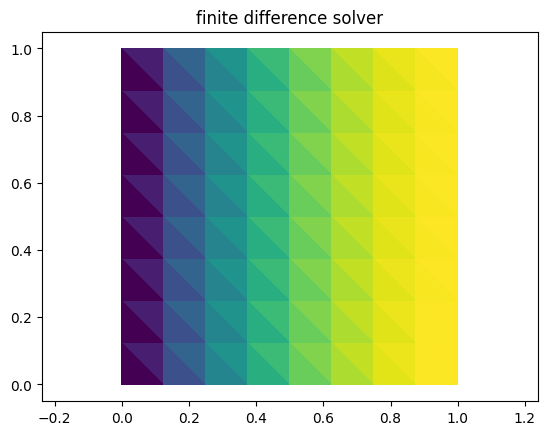

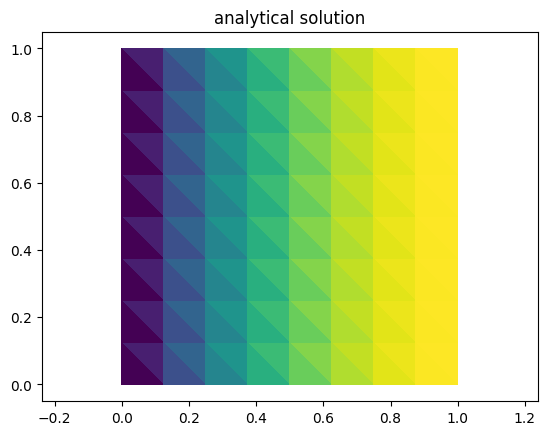

In [25]:
Nx=8

nodes, IEN, ID, boundary_nodes=generate_2d_grid(Nx)
boundary_nodes=[0,9,18,27,36,45,54,63,72,81]
n_eq = 0
for i in range(len(nodes[:, 1])):
    if i in boundary_nodes:
        ID[i] = -1
    else:
        ID[i] = n_eq
        n_eq += 1

N_equations = np.max(ID)+1
N_elements = IEN.shape[0]
N_nodes = nodes.shape[0]
N_dim = nodes.shape[1]

nodes=nodes.T

# Location matrix
LM = np.zeros_like(IEN.T)
for e in range(N_elements):
    for a in range(3):
        LM[a,e] = ID[IEN[e,a]]
# Global stiffness matrix and force vector
K = np.zeros((N_equations, N_equations))
F = np.zeros((N_equations,))
# Loop over elements
for e in range(N_elements):
    k_e = stiffness_2d(nodes[:,IEN[e,:]])
    f_e = force_2d(nodes[:,IEN[e,:]], source_function)
    for a in range(3):
        A = LM[a, e]
        for b in range(3):
            B = LM[b, e]
            if (A >= 0) and (B >= 0):
                K[A, B] += k_e[a, b]
        if (A >= 0):
            F[A] += f_e[a]

# Solve
Psi_interior = np.linalg.solve(K, F)
Psi_A = np.zeros(N_nodes)
for n in range(N_nodes):
    if ID[n] >= 0: # Otherwise Psi should be zero, and we've initialized that already.
        Psi_A[n] = Psi_interior[ID[n]]

plt.tripcolor(nodes[0,:], nodes[1,:], Psi_A, triangles=IEN)
# plt.scatter(nodes[:,0], nodes[:,1],c=Psi_A)
#plt.plot(nodes[boundary_nodes, 0], nodes[boundary_nodes, 1], 'ro')
plt.axis('equal')
plt.title('finite difference solver')
plt.show()

z=psi_analytical(nodes[0])

plt.tripcolor(nodes[0], nodes[1],z, triangles=IEN)
plt.title('analytical solution')
plt.axis('equal')
plt.show()

In [36]:
def ians_example(S):    
    nodes = np.loadtxt('data/esw_nodes_100k.txt')
    
    IEN = np.loadtxt('data/esw_IEN_100k.txt', 
                    dtype=np.int64)
    boundary_nodes = np.loadtxt('data/esw_bdry_100k.txt', 
                                dtype=np.int64)
    # Make all boundary points Dirichlet
    ID = np.zeros(len(nodes), dtype=np.int64)
    n_eq = 0
    for i in range(len(nodes[:,1])):
        if i in boundary_nodes:
            ID[i] = -1
        else:
            ID[i] = n_eq
            n_eq += 1
    N_equations = np.max(ID)+1
    N_elements = IEN.shape[0]
    N_nodes = nodes.shape[0]
    nodes=nodes.T
    # Location matrix
    LM = np.zeros_like(IEN.T)
    for e in range(N_elements):
        for a in range(3):
            LM[a,e] = ID[IEN[e,a]]
    # Global stiffness matrix and force vector
    K = np.zeros((N_equations, N_equations))
    F = np.zeros((N_equations,))
    # Loop over elements
    for e in range(N_elements):
        k_e = stiffness_2d(nodes[:,IEN[e,:]])
        f_e = force_2d(nodes[:,IEN[e,:]], S)
        for a in range(3):
            A = LM[a, e]
            for b in range(3):
                B = LM[b, e]
                if (A >= 0) and (B >= 0):
                    K[A, B] += k_e[a, b]
            if (A >= 0):
                F[A] += f_e[a]
    # Solve
    Psi_interior = np.linalg.solve(K, F)
    Psi_A = np.zeros(N_nodes)
    for n in range(N_nodes):
        if ID[n] >= 0: # Otherwise Psi should be zero, and we've initialized that already.
            Psi_A[n] = Psi_interior[ID[n]]
    plt.tripcolor(nodes[0], nodes[1],Psi_A, triangles=IEN)
    # plt.scatter(nodes[:,0], nodes[:,1],c=Psi_A)
    #plt.plot(nodes[boundary_nodes, 0], nodes[boundary_nodes, 1], 'ro')
    plt.axis('equal')
    plt.title('finite difference solver')
    plt.show()

    return Psi_A

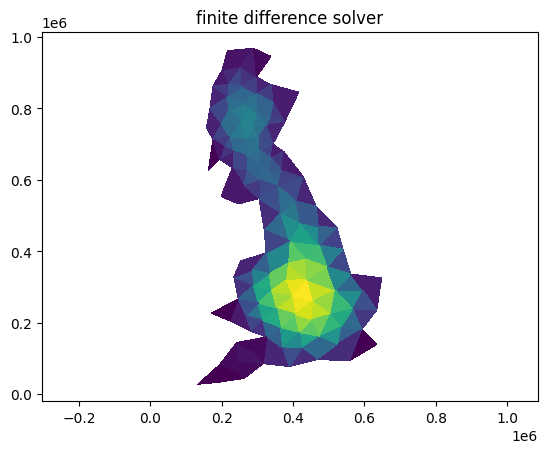

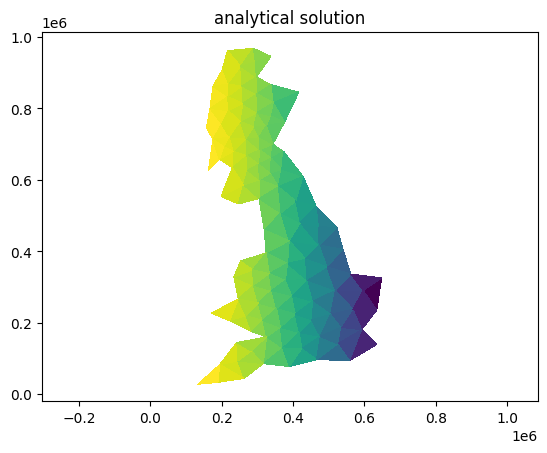

In [39]:
Psi=ians_example(source_function)

nodes = np.loadtxt('data/esw_nodes_100k.txt')
IEN = np.loadtxt('data/esw_IEN_100k.txt', 
                    dtype=np.int64)
nodes=nodes.T
z=psi_analytical(nodes[0])

plt.tripcolor(nodes[0], nodes[1],z, triangles=IEN)
# plt.scatter(nodes[:,0], nodes[:,1])
plt.title('analytical solution')
plt.axis('equal')
plt.show()